Create an S3 client to connect to AWS S3 an then, list all buckets:

In [1]:
import boto3

s3 = boto3.client('s3')

for bucket in s3.list_buckets()['Buckets']:
    print(f"{bucket['Name']}")


mydiabetdatabucket
sagemaker-eu-north-1-850701857503


We download the train.csv file from S3 and load it into pandas:

In [2]:
import pandas as pd

bucket_name = 'mydiabetdatabucket'
file_key = 'diabetes_train.csv'

# Use boto3 to get the file from S3
obj = s3.get_object(Bucket=bucket_name, Key=file_key)

df = pd.read_csv(obj['Body'])


In [3]:
df.head()

,Unnamed: 0,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0,6,148,72,35,0,33.6,0.627,50,1
1,1,1,85,66,29,0,26.6,0.351,31,0
2,2,8,183,64,0,0,23.3,0.672,32,1
3,3,1,89,66,23,94,28.1,0.167,21,0
4,4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
df.drop("Unnamed: 0", axis=1, inplace=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700 entries, 0 to 699
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               700 non-null    int64  
 1   Glucose                   700 non-null    int64  
 2   BloodPressure             700 non-null    int64  
 3   SkinThickness             700 non-null    int64  
 4   Insulin                   700 non-null    int64  
 5   BMI                       700 non-null    float64
 6   DiabetesPedigreeFunction  700 non-null    float64
 7   Age                       700 non-null    int64  
 8   Outcome                   700 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 49.3 KB


There is no null values. (We will check it again later.)

In [6]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000
mean,3.827143,120.541429,68.880000,20.382857,79.880000,31.891286,0.476019,33.124286,0.344286
std,3.364394,32.208854,19.540718,16.032219,115.590119,7.949977,0.337357,11.784558,0.475475
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,63.500000,0.000000,0.000000,27.000000,0.240000,24.000000,0.000000
50%,3.000000,116.500000,72.000000,23.000000,36.500000,32.000000,0.375500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,126.500000,36.500000,0.637000,40.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [7]:
df["Outcome"].value_counts()

0    459
1    241
Name: Outcome, dtype: int64

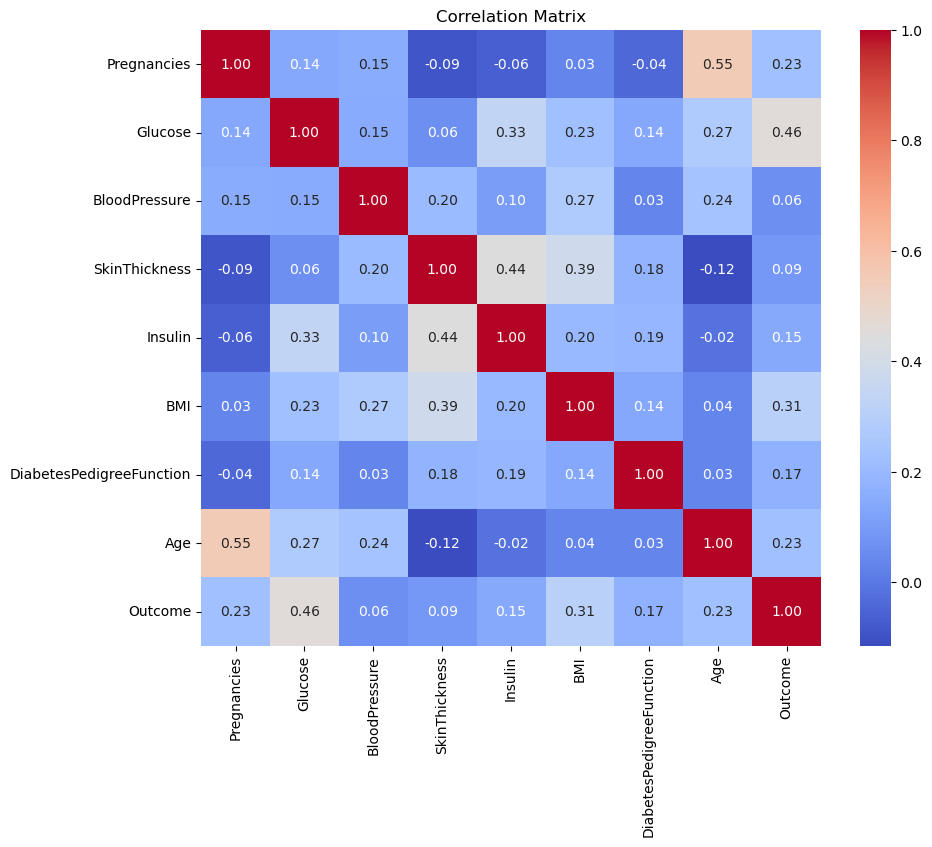

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Matrix
corr = df.corr(numeric_only=True)

# Heatmap 
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()


There is no correlation between features.

Let's check 0 values on some features. Because if they're zero it means they're actually null.

In [9]:
zero_cols = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
for col in zero_cols:
    zero_count = (df[col] == 0).sum()
    print(f"{col} : {zero_count}")


Glucose : 5
BloodPressure : 33
SkinThickness : 209
Insulin : 338
BMI : 10


In [10]:
import numpy as np

zero_cols = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
df[zero_cols] = df[zero_cols].replace(0, np.nan)
df[zero_cols].isnull().sum()

Glucose            5
BloodPressure     33
SkinThickness    209
Insulin          338
BMI               10
dtype: int64

Now it's time to fill those null values with mode or median.

If the distribution has skewness filling with median is more make sense. Otherwise fill with mean value.

In [11]:
for col in df.columns:
    if df[col].isnull().sum() > 0:
        if df[col].skew() > 1:
            df[col].fillna(df[col].median(), inplace=True)
        else:
            df[col].fillna(df[col].mean(), inplace=True)

# Last check
df.isnull().sum()


Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

Let's prepare the data for Train Test Split (We applied this step before Standard Scaling because of preventing data leakage.)

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df.drop('Outcome', axis=1)
y = df['Outcome']

# (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Fit ve transform
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



**Logistic Regression**

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

model = LogisticRegression(max_iter=1000)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)


Accuracy: 0.6642857142857143
Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.76      0.75        92
           1       0.51      0.48      0.49        48

    accuracy                           0.66       140
   macro avg       0.62      0.62      0.62       140
weighted avg       0.66      0.66      0.66       140



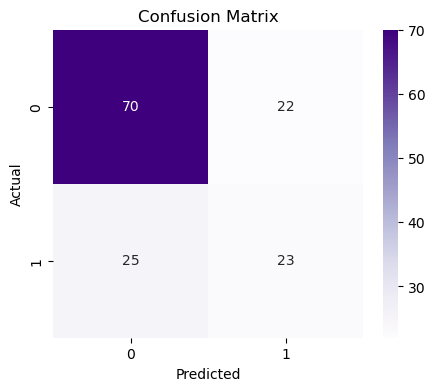

In [15]:
print("Accuracy:", accuracy_score(y_test, y_pred))

# Sınıf detayları
print("Classification Report:\n", classification_report(y_test, y_pred))

import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()



Let's continue with **Random Forest** Model:

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# RF model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

# Results
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))


Accuracy: 0.7142857142857143
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.79      0.78        92
           1       0.59      0.56      0.57        48

    accuracy                           0.71       140
   macro avg       0.68      0.68      0.68       140
weighted avg       0.71      0.71      0.71       140

Confusion Matrix:
 [[73 19]
 [21 27]]


**Let's upload the preprocessed data to our S3:**

In [17]:
df.to_csv("preprocessed_train.csv", index=False)

s3 = boto3.client('s3')
bucket_name = "mydiabetdatabucket"
s3.upload_file("preprocessed_train.csv", bucket_name, "diabetes/preprocessed_train.csv")

SageMaker expects the target label to be in the first column of the CSV file. Let's do it:

In [18]:
label = df.pop('Outcome')
df.insert(0, 'Outcome', label)

df.to_csv("preprocessed_train.csv", index=False)
s3.upload_file("preprocessed_train.csv", "mydiabetdatabucket", "diabetes/preprocessed_train.csv")

**XGBoost**

In [19]:
import sagemaker
from sagemaker.inputs import TrainingInput
from sagemaker.estimator import Estimator

# SageMaker session ve role
session = sagemaker.Session()
role = sagemaker.get_execution_role()

# S3 path
s3_input_path = "s3://mydiabetdatabucket/diabetes/preprocessed_train.csv"

train_input = TrainingInput(s3_data=s3_input_path, content_type="csv")

# XGBoost Estimator
xgb_estimator = Estimator(
    image_uri=sagemaker.image_uris.retrieve("xgboost", session.boto_region_name, version="1.5-1"),
    role=role,
    instance_count=1,
    instance_type="ml.m5.large",  # Kotasını açtırdığın instance tipi
    output_path=f"s3://{session.default_bucket()}/xgboost-output",
    sagemaker_session=session
)

xgb_estimator.set_hyperparameters(
    objective="binary:logistic",
    num_round=100,
    max_depth=5,
    eta=0.2,
    gamma=4,
    subsample=0.7,
    verbosity=1
)

xgb_estimator.fit({"train": train_input})


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pydantic/_internal/_fields.py:172: UserWarning: Field name "json" in "MonitoringDatasetFormat" shadows an attribute in parent "Base"
  warnings.warn(


[05/25/25 15:27:58] INFO     Found credentials from IAM Role:                                   ]8;id=147070;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=371847;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


[05/25/25 15:27:59] INFO     Ignoring unnecessary instance type: None.                            ]8;id=783639;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=129311;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     SageMaker Python SDK will collect telemetry to help us better  ]8;id=593379;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/telemetry/telemetry_logging.py\telemetry_logging.py]8;;\:]8;id=191981;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/telemetry/telemetry_logging.py#91\91]8;;\
                             understand our user's needs, diagnose issues, and deliver                             
                             additional features.                                                                  
                             To opt out of telemetry, please disable via TelemetryOptOut                           
                             parameter in SDK defaults config. For more information, refer                         
                             to                                                                                    
                             https://sagemaker.readthedocs.io/en/stable/overview.html#confi                        
                             guring-and-using-defaults-with-the-sagemaker-python-sdk.                              

                    INFO     Creating training-job with name:                                       ]8;id=42738;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=828752;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#1042\1042]8;;\
                             sagemaker-xgboost-2025-05-25-15-27-59-408                                             

2025-05-25 15:28:00 Starting - Starting the training job...
2025-05-25 15:28:33 Downloading - Downloading input data......
2025-05-25 15:29:13 Downloading - Downloading the training image......
2025-05-25 15:30:24 Training - Training image download completed. Training in progress.
2025-05-25 15:30:24 Uploading - Uploading generated training model/miniconda3/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
[2025-05-25 15:30:18.855 ip-10-0-166-250.eu-north-1.compute.internal:7 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2025-05-25 15:30:18.881 ip-10-0-166-250.eu-north-1.compute.internal:7 INFO profiler_config_parser.py:111] User has disabled profiler.
[2025-05-25:15:30:19:INFO] Imported framework sagemaker_xgboost_container.training
[2025-05-25:15:30:19:INFO] Failed to parse hyperpa

We define an XGBoost model using SageMaker.
It reads data from S3, trains it on an ml.m5.large instance, and saves the model output back to S3.

Let's Deploy the model and see the results:

In [20]:
from sagemaker.serializers import CSVSerializer
from sagemaker.predictor import Predictor

# Deploy the trained model to a SageMaker endpoint
predictor = xgb_estimator.deploy(
    initial_instance_count=1,
    instance_type="ml.m5.large",  
    serializer=CSVSerializer()   
)


[05/25/25 15:31:16] INFO     Creating model with name: sagemaker-xgboost-2025-05-25-15-31-16-649    ]8;id=720152;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=755904;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#4094\4094]8;;\

[05/25/25 15:31:17] INFO     Creating endpoint-config with name                                     ]8;id=549200;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=115735;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#6019\6019]8;;\
                             sagemaker-xgboost-2025-05-25-15-31-16-649                                             

                    INFO     Creating endpoint with name sagemaker-xgboost-2025-05-25-15-31-16-649  ]8;id=426689;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=766496;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#4841\4841]8;;\

--------!

We successfully deployed the model. Now it's time to get classification report. I have a test.csv file and let's load it:

In [21]:
df_test = pd.read_csv("test.csv")

y_true = df_test["Outcome"]

X_test = df_test.drop(columns=["Outcome"])

X_test_np = X_test.values.astype("float32")

Fetch the prediction from endpoint:

In [22]:
response = predictor.predict(X_test_np).decode("utf-8")

y_pred_probs = [float(x) for x in response.strip().split('\n')]

y_pred = [1 if p > 0.5 else 0 for p in y_pred_probs]


Added to prediction results to DataFrame:

In [23]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("Accuracy:", accuracy_score(y_true, y_pred))
print("\nClassification Report:\n", classification_report(y_true, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))


Accuracy: 0.75

Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.93      0.82        41
           1       0.81      0.48      0.60        27

    accuracy                           0.75        68
   macro avg       0.77      0.70      0.71        68
weighted avg       0.76      0.75      0.73        68

Confusion Matrix:
 [[38  3]
 [14 13]]


**Hyperparameter Tuning**

In [24]:
from sagemaker.tuner import HyperparameterTuner, ContinuousParameter, IntegerParameter


In [34]:
hyperparameter_ranges = {
    'max_depth': IntegerParameter(3, 10),
    'eta': ContinuousParameter(0.01, 0.3),
    'gamma': ContinuousParameter(0, 10),
    'min_child_weight': IntegerParameter(1, 10),
    'subsample': ContinuousParameter(0.5, 1.0),
    'colsample_bytree': ContinuousParameter(0.5, 1.0)
}


In [35]:
objective_metric_name = "validation:auc"
objective_type = "Maximize"



In [36]:
tuner = HyperparameterTuner(
    estimator=xgb_estimator,
    objective_metric_name=objective_metric_name,
    hyperparameter_ranges=hyperparameter_ranges,
    metric_definitions=[
        {'Name': 'validation:auc', 'Regex': 'auc:([0-9\\.]+)'}
    ],
    max_jobs=10,
    max_parallel_jobs=2,
    objective_type=objective_type
)



Split the data into train(80%) and test (20%):

In [37]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df["Outcome"])


In [38]:
train_df.to_csv("train_sagemaker.csv", index=False)
val_df.to_csv("validation_sagemaker.csv", index=False)


I upload files to the correct folder in S3. SageMaker can find and use them for model training and tuning.

In [39]:
s3.upload_file("train_sagemaker.csv", bucket_name, "diabetes/train_sagemaker.csv")
s3.upload_file("validation_sagemaker.csv", bucket_name, "diabetes/validation_sagemaker.csv")


In [40]:
train_input = TrainingInput(s3_data=f"s3://{bucket_name}/diabetes/train_sagemaker.csv", content_type="csv")
validation_input = TrainingInput(s3_data=f"s3://{bucket_name}/diabetes/validation_sagemaker.csv", content_type="csv")


In [41]:
tuner.fit({'train': train_input, 'validation': validation_input})


[05/25/25 15:42:27] INFO     Creating hyperparameter tuning job with name:                          ]8;id=927205;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=306105;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#3383\3383]8;;\
                             sagemaker-xgboost-250525-1542                                                         

..................................................................................!


In [42]:
tuner.wait()


!


Deploy the final model:

In [43]:
best_predictor = tuner.deploy(
    initial_instance_count=1,
    instance_type="ml.m5.large",
    serializer=CSVSerializer()
)



2025-05-25 15:46:32 Starting - Found matching resource for reuse
2025-05-25 15:46:32 Downloading - Downloading the training image
2025-05-25 15:46:32 Training - Training image download completed. Training in progress.
2025-05-25 15:46:32 Uploading - Uploading generated training model
2025-05-25 15:46:32 Completed - Resource reused by training job: sagemaker-xgboost-250525-1542-005-4955e7f9


[05/25/25 15:57:53] INFO     Creating model with name: sagemaker-xgboost-2025-05-25-15-57-53-414    ]8;id=895879;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=212483;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#4094\4094]8;;\

[05/25/25 15:57:54] INFO     Creating endpoint-config with name                                     ]8;id=7847;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=927580;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#6019\6019]8;;\
                             sagemaker-xgboost-250525-1542-004-e6dab3b6                                            

                    INFO     Creating endpoint with name sagemaker-xgboost-250525-1542-004-e6dab3b6 ]8;id=150405;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=967991;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#4841\4841]8;;\

------!

Final classification Report:

In [45]:
response = best_predictor.predict(X_test_np).decode("utf-8")
y_pred_probs = [float(x) for x in response.strip().split('\n')]
y_pred = [1 if p > 0.5 else 0 for p in y_pred_probs]

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print("Accuracy:", accuracy_score(y_true, y_pred))
print("\nClassification Report:\n", classification_report(y_true, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))


Accuracy: 0.7794117647058824

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.95      0.84        41
           1       0.88      0.52      0.65        27

    accuracy                           0.78        68
   macro avg       0.81      0.73      0.74        68
weighted avg       0.80      0.78      0.76        68

Confusion Matrix:
 [[39  2]
 [13 14]]


We lastly deleted the endpoint to avoid extra costs and keep our AWS resources clean:

In [46]:
best_predictor.delete_endpoint()


[05/25/25 16:05:25] INFO     Deleting endpoint configuration with name:                             ]8;id=523999;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=344266;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#4995\4995]8;;\
                             sagemaker-xgboost-250525-1542-004-e6dab3b6                                            

                    INFO     Deleting endpoint with name:                                           ]8;id=292161;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=510679;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#4985\4985]8;;\
                             sagemaker-xgboost-250525-1542-004-e6dab3b6                                            